In [1]:
import warnings
from io import BytesIO
from pathlib import Path
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
import os

import pandas as pd
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

from sklearn.metrics import brier_score_loss, roc_auc_score
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.vaep.formula import value
import socceraction.vaep.formula as vaepformula
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
import tqdm
import random

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab

import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.formula as vaepformula

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)


In [2]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
from socceraction.data.wyscout import PublicWyscoutLoader



In [3]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [4]:
comp = [
     #'England'
     #'France',
     #'Germany',
     'Italy',
     #'Spain'
]

In [5]:
##DA qui

In [6]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [7]:
selected_competitions = competitions[(competitions['country_name'] =='Italy')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
0,524,181248,Italy,Italian first division,male,2017/2018


### Append home and away goals to the game dataset

In [8]:
## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in selected_competitions['country_name']:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)
df_matches= df_matches.reset_index()

In [9]:
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    home_score.append(df_matches['teamsData'][i][home_id]['score'])
    away_score.append(df_matches['teamsData'][i][away_id]['score'])


In [10]:
df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

In [11]:
df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181248,2576335,"Lazio - Internazionale, 2 - 3",524,2,3
1,181248,2576336,"Sassuolo - Roma, 0 - 1",524,0,1
2,181248,2576329,"Cagliari - Atalanta, 1 - 0",524,1,0
3,181248,2576330,"Chievo - Benevento, 1 - 0",524,1,0
4,181248,2576331,"Udinese - Bologna, 1 - 0",524,1,0


In [12]:
# Get games from all selected competitions
games = pd.concat([
    wyscout.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])

In [13]:
games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,2576335,524,181248,2018-05-20 18:45:00,38,3162,3161
1,2576336,524,181248,2018-05-20 18:45:00,38,3315,3158
2,2576329,524,181248,2018-05-20 16:00:00,38,3173,3172
3,2576330,524,181248,2018-05-20 16:00:00,38,3165,3219
4,2576331,524,181248,2018-05-20 16:00:00,38,3163,3166


In [14]:
match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

In [15]:
games[["home_team_id", "away_team_id", "game_date","home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,3162,3161,2018-05-20 18:45:00,2,3
1,3315,3158,2018-05-20 18:45:00,0,1
2,3173,3172,2018-05-20 16:00:00,1,0
3,3165,3219,2018-05-20 16:00:00,1,0
4,3163,3166,2018-05-20 16:00:00,1,0
...,...,...,...,...,...
375,3315,3193,2017-08-20 18:45:00,0,0
376,3163,3165,2017-08-20 18:45:00,1,2
377,3172,3158,2017-08-20 16:00:00,0,1
378,3194,3187,2017-08-19 18:45:00,1,3


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


### Convert event to actions

# DO NOT RUN

In [26]:
### DO NOT RUN
#Convert events to SPADL 
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
atomic_actions = {}

for game in games_verbose:
    # load data
    teams.append(wyscout.teams(game.game_id))
    players.append(wyscout.players(game.game_id))
    events = wyscout.events(game.game_id)
    # convert data
    actions[game.game_id] = convert_to_actions(events, game.home_team_id)
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions[game.game_id])

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 380/380 [1:50:23<00:00, 17.43s/it]


In [17]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Ita"

In [20]:
# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = atomic_actions[game_id]

NameError: name 'players' is not defined

In [18]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [19]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,3162,Lazio,SS Lazio
1,3161,Internazionale,FC Internazionale Milano
2,3158,Roma,AS Roma
3,3315,Sassuolo,US Sassuolo Calcio
4,3173,Cagliari,Cagliari Calcio
5,3172,Atalanta,Atalanta Bergamasca Calcio
6,3165,Chievo,AC Chievo Verona
7,3219,Benevento,Benevento Calcio
8,3166,Bologna,Bologna FC 1909
9,3163,Udinese,Udinese Calcio


In [20]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.country_name == "Italy") 
                  & (games.home_team_name_short == "Internazionale")
                  & (games.away_team_name_short== "Milan")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2576034,196692208,0,1,2.532778,3157,135927,51.45,32.64,16.8,7.48,0,0,pass,foot,André Silva,Milan,AC Milan
1,2576034,196692208,1,1,3.325886,3157,37732,68.25,40.12,0.0,0.00,23,0,receival,foot,L. Biglia,Milan,AC Milan
2,2576034,196692209,2,1,4.118994,3157,37732,68.25,40.12,-10.5,15.64,0,0,pass,foot,L. Biglia,Milan,AC Milan
3,2576034,196692209,3,1,5.348591,3157,285109,57.75,55.76,0.0,0.00,23,0,receival,foot,F. Kessié,Milan,AC Milan
4,2576034,196692210,4,1,6.578187,3157,285109,57.75,55.76,-12.6,10.88,0,0,pass,foot,F. Kessié,Milan,AC Milan


In [34]:
for i in atomic_actions.columns:
    print (i)

game_id
original_event_id
action_id
period_id
time_seconds
team_id
player_id
x
y
dx
dy
type_id
bodypart_id
type_name
bodypart_name
player_name
team_name_short
team_name


2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , M. Icardi 62'


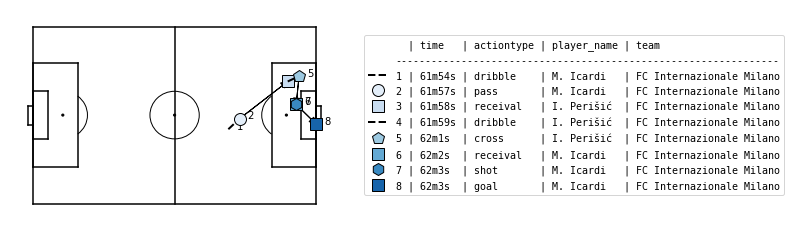

In [24]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

In [25]:
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role']]

Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

## Compute features and labels

In [26]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [ ]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [28]:
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:
    for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {features_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        gamestates = fs.gamestates(atomicspadl.add_names(actions), 3)
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
        featurestore[f"game_{game.game_id}"] = X

Generating and storing features in /Users/leonardoyang/Desktop/data-fifa/Ita/atomic_features.h5: 100%|██████████| 380/380 [01:07<00:00,  5.65it/s]


In [309]:
yfns = [lab.scores, lab.concedes, lab.goal_from_shot]

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y


Computing and storing labels in /Users/leonardoyang/Desktop/data-fifa/Ita/atomic_labels.h5: 100%|██████████| 380/380 [01:02<00:00,  6.10it/s]


In [ ]:
#Labels
#goal = True if goal from a shot
#Score = True if within next 10 actions goal
#concedes = True if within next 10 actions goal
#Chi ha palla è score, se durante azione c'è qualche intervento avversario c'è concedes = true.
#Goal è true solo se shot, score e concedes ci sono comunque.

### Compute Probabilities

In [38]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [39]:
traingames, testgames = train_test_split(games, test_size=0.3, random_state=42, shuffle=False)

In [40]:
testgames

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score,country_name,competition_name,competition_gender,season_name,home_team_name_short,home_team_name,away_team_name_short,away_team_name
266,2576073,524,181248,2017-11-05 14:00:00,12,3176,3158,2,4,Italy,Italian first division,male,2017/2018,Fiorentina,ACF Fiorentina,Roma,AS Roma
267,2576076,524,181248,2017-11-05 14:00:00,12,3159,3219,2,1,Italy,Italian first division,male,2017/2018,Juventus,Juventus FC,Benevento,Benevento Calcio
268,2576075,524,181248,2017-11-05 11:30:00,12,3161,3185,1,1,Italy,Italian first division,male,2017/2018,Internazionale,FC Internazionale Milano,Torino,Torino FC
269,2576074,524,181248,2017-11-04 19:45:00,12,3193,3164,0,2,Italy,Italian first division,male,2017/2018,Genoa,Genoa CFC,Sampdoria,UC Sampdoria
270,2576070,524,181248,2017-11-04 17:00:00,12,3166,3197,2,3,Italy,Italian first division,male,2017/2018,Bologna,Bologna FC 1909,Crotone,FC Crotone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,2575967,524,181248,2017-08-20 18:45:00,1,3315,3193,0,0,Italy,Italian first division,male,2017/2018,Sassuolo,US Sassuolo Calcio,Genoa,Genoa CFC
376,2575968,524,181248,2017-08-20 18:45:00,1,3163,3165,1,2,Italy,Italian first division,male,2017/2018,Udinese,Udinese Calcio,Chievo,AC Chievo Verona
377,2575959,524,181248,2017-08-20 16:00:00,1,3172,3158,0,1,Italy,Italian first division,male,2017/2018,Atalanta,Atalanta Bergamasca Calcio,Roma,AS Roma
378,2575962,524,181248,2017-08-19 18:45:00,1,3194,3187,1,3,Italy,Italian first division,male,2017/2018,Hellas Verona,Hellas Verona FC,Napoli,SSC Napoli


In [48]:
# 1. Select feature set X
xfns = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 1

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"): #aggiungi azioni di ogni partita
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

X,Y = getXY(traingames, Xcols)
#print("X:", list(X.columns))
#print("Y:", list(Y.columns))
X = X.fillna(0)

Selecting label: 100%|██████████| 266/266 [00:02<00:00, 91.59it/s] 


In [361]:
#'goalscore_team','goalscore_opponent' = goal segnati fin'ora dalla squadra che fa l'ultima azione.

In [41]:
games.iloc[:1]

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score,country_name,competition_name,competition_gender,season_name,home_team_name_short,home_team_name,away_team_name_short,away_team_name
0,2576335,524,181248,2018-05-20 18:45:00,38,3162,3161,2,3,Italy,Italian first division,male,2017/2018,Lazio,SS Lazio,Internazionale,FC Internazionale Milano


In [42]:
Laz_Int = pd.HDFStore(spadl_h5) [f"actions/game_2576335"]

In [43]:
Laz_Int

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id
0,2576335,253668302,0,1,2.417590,3161,3344,53.55,34.00,11.55,5.44,0,0
1,2576335,253668302,1,1,3.161001,3161,116349,65.10,39.44,0.00,0.00,23,0
2,2576335,253668303,2,1,3.904412,3161,116349,65.10,39.44,1.05,22.44,0,0
3,2576335,253668303,3,1,5.194311,3161,135903,66.15,61.88,0.00,0.00,23,0
4,2576335,253668304,4,1,6.484211,3161,135903,66.15,61.88,3.15,-12.92,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2164,2576335,253670075,2164,2,2930.851111,3161,206314,43.05,57.12,-6.30,-9.52,0,0
2165,2576335,253670019,2165,2,2931.812411,3162,37745,36.75,47.60,0.00,0.00,10,0
2166,2576335,253670019,2166,2,2931.812411,3162,37745,36.75,47.60,-8.40,12.24,0,0
2167,2576335,253670019,2167,2,2933.961420,3162,40806,28.35,59.84,0.00,0.00,23,0


In [44]:
X[['goalscore_team','goalscore_opponent', 'goalscore_diff']][:2169].head()

,goalscore_team,goalscore_opponent,goalscore_diff
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [144]:
#Rimuovi portieri
gk = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
gk = gk[['wyId','shortName','role']]

Role = []
for i in range(len(gk)):
    Role.append(gk['role'][i]['name'])

gk['Role'] = Role
gk.drop('role', axis = 1,inplace = True)

gk = gk[gk.Role == 'Goalkeeper']

In [148]:
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,nickname,team_name_short,team_name
0,2576034,196692208,0,1,2.532778,3157,135927,51.45,32.64,16.80,7.48,0,0,pass,foot,André Miguel Valente Silva,André Silva,Milan,AC Milan
1,2576034,196692208,1,1,3.325886,3157,37732,68.25,40.12,0.00,0.00,23,0,receival,foot,Lucas Rodrigo Biglia,L. Biglia,Milan,AC Milan
2,2576034,196692209,2,1,4.118994,3157,37732,68.25,40.12,-10.50,15.64,0,0,pass,foot,Lucas Rodrigo Biglia,L. Biglia,Milan,AC Milan
3,2576034,196692209,3,1,5.348591,3157,285109,57.75,55.76,0.00,0.00,23,0,receival,foot,Franck Yannick Kessié,F. Kessié,Milan,AC Milan
4,2576034,196692210,4,1,6.578187,3157,285109,57.75,55.76,-12.60,10.88,0,0,pass,foot,Franck Yannick Kessié,F. Kessié,Milan,AC Milan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010,2576034,196693773,2010,2,2898.704446,3157,286226,49.35,36.04,0.00,0.00,23,0,receival,foot,Manuel Locatelli,M. Locatelli,Milan,AC Milan
2011,2576034,196693774,2011,2,2900.003568,3157,286226,49.35,36.04,-12.60,3.40,21,0,dribble,foot,Manuel Locatelli,M. Locatelli,Milan,AC Milan
2012,2576034,196693760,2012,2,2901.758353,3161,20626,36.75,39.44,4.20,4.08,9,0,tackle,foot,Eder Citadin Martins,Eder,Internazionale,FC Internazionale Milano
2013,2576034,196693763,2013,2,2903.139371,3161,20626,40.95,43.52,0.00,0.00,8,0,foul,foot,Eder Citadin Martins,Eder,Internazionale,FC Internazionale Milano


## Train 

In [49]:
%%time
# 3. train classifiers F(X) = Y
import xgboost

Y_hat = pd.DataFrame()
models = {}
for col in list(Y.columns):
    model = xgboost.XGBClassifier(n_estimators=48, max_depth=3, n_jobs=-3, verbosity=1)
    model.fit(X, Y[col])
    models[col] = model

CPU times: user 3min 22s, sys: 2.57 s, total: 3min 25s
Wall time: 1min 3s


In [50]:
testX, testY = getXY(testgames,Xcols)

Selecting label: 100%|██████████| 114/114 [00:00<00:00, 118.68it/s]


In [51]:
models['scores'].predict_proba(testX)

array([[0.9988913 , 0.00110872],
       [0.99850047, 0.00149955],
       [0.9987447 , 0.00125526],
       ...,
       [0.860391  , 0.13960901],
       [0.9983507 , 0.0016493 ],
       [0.99644065, 0.00355936]], dtype=float32)

In [52]:
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

def evaluate(y, y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, y_hat))

for col in testY.columns:
    Y_hat[col] = [p[1] for p in models[col].predict_proba(testX)] #[1] = prob del True
    print(f"### Y: {col} ###")
    evaluate(testY[col], Y_hat[col])


### Y: scores ###
  Brier score: 0.00860 (0.83050)
  log loss score: 0.04283 (0.73710)
  ROC AUC: 0.86144
### Y: concedes ###
  Brier score: 0.00185 (0.89897)
  log loss score: 0.01151 (0.77535)
  ROC AUC: 0.84851


In [53]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(testgames.game_id, "Loading actions of each game"):    #azioni per ogni partita del test
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 114/114 [00:01<00:00, 65.69it/s]


## VAEP

In [113]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(testgames))

nb of games: 114


In [114]:
#For each game in the test set, append the predictions and compute vaep
A = []
for game in tqdm.tqdm(list(testgames.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 114/114 [00:07<00:00, 15.37it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [119]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:20]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
176,21384,C. Immobile,15.195257,14.975224,0.220034,798
3,122,D. Mertens,12.667634,12.599599,0.068036,862
286,89186,P. Dybala,12.456669,12.252398,0.204271,1333
333,206314,M. Icardi,12.093246,11.940374,0.152872,467
31,8327,E. Džeko,11.037632,10.832235,0.205397,647
12,3323,G. Higuaín,9.901367,9.655997,0.245370,741
167,21298,Nicolas,9.080692,0.256887,8.823806,816
67,20479,F. Quagliarella,8.457962,8.220970,0.236992,517
181,21494,A. Cordaz,7.207759,0.441993,6.765766,608
29,8148,Iago Falqué,6.908740,6.620053,0.288687,1204


In [120]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 900] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
175,21384,C. Immobile,15.195257,14.975224,0.220034,798,2816,0.485644,0.478612,0.007032
285,89186,P. Dybala,12.456669,12.252398,0.204271,1333,2491,0.450060,0.442680,0.007380
102,20663,C. Théréau,6.554175,6.289788,0.264387,775,1360,0.433732,0.416236,0.017496
2,122,D. Mertens,12.667634,12.599599,0.068036,862,3142,0.362854,0.360905,0.001949
242,25849,F. Ghoulam,4.084221,3.579898,0.504323,2000,1033,0.355837,0.311898,0.043939
332,206314,M. Icardi,12.093246,11.940374,0.152872,467,3103,0.350755,0.346321,0.004434
30,8327,E. Džeko,11.037632,10.832235,0.205397,647,3177,0.312681,0.306862,0.005819
214,22552,V. Belec,4.683902,0.231510,4.452392,355,1386,0.304150,0.015033,0.289116
11,3323,G. Higuaín,9.901367,9.655997,0.245370,741,2977,0.299336,0.291918,0.007418
318,135150,A. Cornelius,3.150308,3.145500,0.004808,237,1007,0.281557,0.281127,0.000430


In [121]:
stats.sort_values("defensive_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
214,22552,V. Belec,4.683902,0.231510,4.452392,355,1386,0.304150,0.015033,0.289116
166,21298,Nicolas,9.080692,0.256887,8.823806,816,3429,0.238338,0.006742,0.231596
92,20632,C. Puggioni,5.541093,0.134743,5.406349,557,2112,0.236126,0.005742,0.230384
147,21098,A. Gomis,6.243627,0.467355,5.776272,629,2416,0.232585,0.017410,0.215176
177,21415,A. Brignoli,2.321262,0.076502,2.244760,388,1198,0.174385,0.005747,0.168638
180,21494,A. Cordaz,7.207759,0.441993,6.765766,608,3622,0.179099,0.010983,0.168117
310,134413,A. Cragno,4.787219,0.154210,4.633009,374,2714,0.158751,0.005114,0.153637
232,23705,M. Sportiello,5.729925,0.013886,5.716039,638,3403,0.151541,0.000367,0.151174
118,20832,A. Consigli,5.365910,0.176783,5.189126,646,3542,0.136344,0.004492,0.131852
67,20483,A. Mirante,4.674450,0.257962,4.416488,597,3171,0.132671,0.007322,0.125350


2017-10-15 18:45:00, FC Internazionale Milano - AC Milan : 3-2 , Mauro Emanuel Icardi Rivero  27


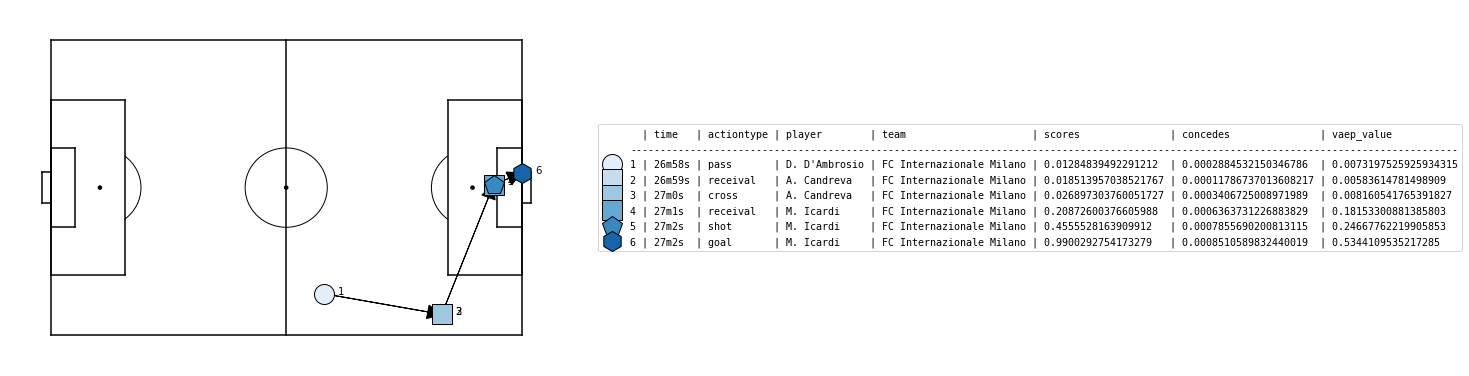

In [138]:
#For each game in the test set, append the predictions and compute vaep
A = []
actions = pd.HDFStore(spadl_h5) [f"actions/game_2576034"]
actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
)
preds = pd.HDFStore(predictions_h5) [f"game_2576034"]
values = vaepformula.value(actions, preds.scores, preds.concedes)
A.append(pd.concat([actions, preds, values], axis=1))

A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)

#Plot
a = A.copy()
#Actions.type_name
pos = a[a.type_name == 'goal' ][0:1].action_id.values[0]
a = a[pos-5 : pos+1].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

game = games[(games.country_name == "Italy") & (games.home_team_name_short == "Internazionale") & (games.away_team_name_short== "Milan")]
g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name",'scores','concedes','vaep_value']]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player", "team",'scores','concedes','vaep_value'],
    zoom=False,
    figsize=10
)

In [131]:
A.type_name.unique()

array(['pass', 'receival', 'interception', 'out', 'throw_in', 'dribble',
       'clearance', 'offside', 'freekick', 'foul', 'take_on', 'cross',
       'corner', 'goalkick', 'shot', 'tackle', 'keeper_save', 'goal',
       'bad_touch', 'owngoal', 'shot_penalty'], dtype=object)

In [133]:
#Plot
a = A.copy()
#Actions.type_name
pos = a[a.type_name == 'keeper_save' ][4:5].action_id.values[0]
a = a[pos-5 : pos+12].copy()

a["start_x"] = a.x
a["start_y"] = a.y
a["end_x"] = a.x + a.dx
a["end_y"] = a.y + a.dy

g = game.iloc[0]
minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
print(game_info)

   
a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "nickname", "team_name",'scores','concedes','vaep_value']]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    label=labels,
    labeltitle=["time", "actiontype", "player", "team",'scores','concedes','vaep_value'],
    zoom=False,
    figsize=10
)


AttributeError: 'Pandas' object has no attribute 'iloc'

In [134]:
A.groupby('type_name').count()['action_id'].reset_index().sort_values('action_id', ascending = False)

,type_name,action_id
14,pass,716
15,receival,627
9,interception,205
4,dribble,150
12,out,43
20,throw_in,38
6,freekick,36
3,cross,31
5,foul,30
16,shot,30
